In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
obs_df = pd.read_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv')

bootstrap_dfs = {
    ct: pd.read_csv(f'../../interneuron-reward-data/processed/{ct}_corr_bootstrap.csv')
    for ct in ('pyr', 'vip', 'pv')
}

In [4]:
def get_change(obs_df, cell_type: str) -> pd.DataFrame:
    d1 = obs_df.query('(day == 1) and (cell_type == @cell_type)').set_index('cell_id')
    d7 = obs_df.query('(day == 7) and (cell_type == @cell_type)').set_index('cell_id')
    if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
        warnings.warn('Index not completely matching.')
    change = d1.copy()
    change['reward'] = d7['reward'] - d1['reward']
    change['tone + delay'] = d7['tone + delay'] - d1['tone + delay']
    return change

In [6]:
for tr_component, ct in itertools.product(['tone + delay', 'reward'], ['pyr', 'vip', 'pv']):
    changes_by_mouse = get_change(obs_df, ct).groupby('mouse_id').mean()[tr_component]
    print(f'{ct} {tr_component}: {changes_by_mouse.mean():.3f} (range {changes_by_mouse.min():.3f} to {changes_by_mouse.max():.3f})')

pyr tone + delay: 0.082 (range -0.024 to 0.226)
vip tone + delay: -0.065 (range -0.199 to 0.071)
pv tone + delay: -0.049 (range -0.216 to 0.144)
pyr reward: -0.141 (range -0.381 to 0.145)
vip reward: 0.161 (range -0.090 to 0.361)
pv reward: 0.014 (range -0.201 to 0.160)


<ipython-input-4-5eebf9752fee>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
<ipython-input-4-5eebf9752fee>:5: UserWarning: Index not completely matching.
  warnings.warn('Index not completely matching.')


In [4]:
def vertical_rects(x, y_min, y_max, width=0.5, **pltargs):
    label = pltargs.pop('label', None)
    for i, (x_i, ymin_i, ymax_i) in enumerate(zip(x, y_min, y_max)):
        fill = plt.fill_between(
            [x_i - width/2., x_i + width/2.], [ymin_i, ymin_i], [ymax_i, ymax_i], 
            **pltargs
        )
        if (i == 0) and (label is not None):
            fill.set_label(label)

In [5]:
stat_thresholds = {
    0.05: '*',
    0.01: '**',
}

<ipython-input-3-5eebf9752fee>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
<ipython-input-3-5eebf9752fee>:5: UserWarning: Index not completely matching.
  warnings.warn('Index not completely matching.')


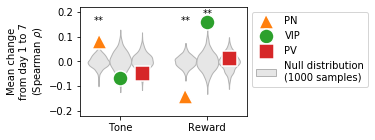

In [6]:
# Plot null distributions as violins
null_arr = np.array([
    bootstrap_dfs[ct].query('(trial_component == @tr_component) and (day == "delta")')['spearman']
    for tr_component, ct in itertools.product(['tone + delay', 'reward'], ['pyr', 'vip', 'pv'])
]).T
x_positions = [-0.5, 0, 0.5, 1.5, 2, 2.5]

plt.figure(figsize=(3, 2))
plt.subplot(111)
violins = plt.violinplot(null_arr, x_positions, showextrema=False)

for i, violin in enumerate(violins['bodies']):
    violin.set_edgecolor((0.7,) * 3)
    violin.set_facecolor((0.9,) * 3)
    violin.set_alpha(1)
    if i == 0:
        violin.set_label('Null distribution\n(1000 samples)')

# Plot observed values
y_obs = [
    get_change(obs_df, ct).groupby('mouse_id').mean()[tr_component].mean()
    for tr_component, ct in itertools.product(['tone + delay', 'reward'], ['pyr', 'vip', 'pv'])
]
labels = ['PN', 'VIP', 'PV']
shapes = ['^', 'o', 's']
for i, (x_pos, y) in enumerate(zip(x_positions, y_obs)):
    pt = plt.plot(x_pos, y, shapes[i%3], color=sns.color_palette()[i%3+1], markersize=15, markeredgecolor='w', mew=1.5)
    if i < 3:
        pt[0].set_label(labels[i])

# Add statistical annotations
for i, x_pos in enumerate(x_positions):
    for stat_thresh in [0.01, 0.05]:
        if (y_obs[i] < np.percentile(null_arr[:, i], 100 * stat_thresh/2.)
           ) or (y_obs[i] > np.percentile(null_arr[:, i], 100 * (1-stat_thresh/2.))):
            plt.annotate(
                stat_thresholds[stat_thresh], 
                (x_pos, max(0.15, y_obs[i] + 0.02)), 
                ha='center'
            )
            break

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.xticks([0, 2], ['Tone', 'Reward'])
plt.ylim(-0.22, 0.22)
plt.ylabel('Mean change\nfrom day 1 to 7\n(Spearman $\\rho$)')

plt.savefig(f'../img/bootstrap/all_celltypes_change_corr.png', dpi=600, bbox_inches='tight')
plt.savefig(f'../img/bootstrap/all_celltypes_change_corr.svg', bbox_inches='tight')

plt.show()